In [1]:
''' Collection of functions and tools for the needs of 02450 Introduction to Machine Learning course.'''
from pylab import *

def remove_zero_cols(m):
    '''Function removes from given matrix m the column vectors containing only zeros.'''
    rows = range(m.shape[0])
    cols = np.nonzero(sum(abs(m)))[1].tolist()[0]
    return m[np.ix_(rows,cols)]

def remove_zero_rows(m):
    '''Function removes from given matrix m the row vectors containing only zeros.'''
    rows = np.nonzero(sum(abs(m.T)).T)[0].tolist()[0]
    cols = range(m.shape[1])
    return m[np.ix_(rows,cols)]

def remove_zero_rows_and_cols(m):
    '''Function removes from given matrix m the row vectors and the column vectors containing only zeros.'''
    rows = np.nonzero(sum(abs(m.T)).T)[0].tolist()[0]
    cols = np.nonzero(sum(abs(m)))[1].tolist()[0]
    return m[np.ix_(rows,cols)]


def bmplot(yt, xt, X):
    ''' Function plots matrix X as image with lines separating fields. '''
    imshow(X,interpolation='none',cmap='bone')
    xticks(range(0,len(xt)), xt)
    yticks(range(0,len(yt)), yt)
    for i in range(0,len(yt)):
        axhline(i-0.5, color='black')
    for i in range(0,len(xt)):
        axvline(i-0.5, color='black')


def glm_validate(X,y,cvf=10):
    ''' Validate linear regression model using 'cvf'-fold cross validation.
        The loss function computed as mean squared error on validation set (MSE).
        Function returns MSE averaged over 'cvf' folds.

        Parameters:
        X       training data set
        y       vector of values
        cvf     number of crossvalidation folds        
    '''
    from sklearn import cross_validation, linear_model
    CV = cross_validation.KFold(X.shape[0],cvf)
    validation_error=np.empty(cvf)
    f=0
    for train_index, test_index in CV:
        X_train = X[train_index]
        y_train = y[train_index]
        X_test = X[test_index]
        y_test = y[test_index]
        m = linear_model.LinearRegression().fit(X_train, y_train)
        validation_error[f] = np.square(y_test-m.predict(X_test)).sum()/y_test.shape[0]
        f=f+1
    return validation_error.mean()
        

def feature_selector_lr(X,y,cvf=10,features_record=None,loss_record=None):
    ''' Function performs feature selection for linear regression model using
        'cvf'-fold cross validation. The process starts with empty set of
        features, and in every recurrent step one feature is added to the set
        (the feature that minimized loss function in cross-validation.)

        Parameters:
        X       training data set
        y       vector of values
        cvf     number of crossvalidation folds

        Returns:
        selected_features   indices of optimal set of features
        features_record     boolean matrix where columns correspond to features
                            selected in subsequent steps
        loss_record         vector with cv errors in subsequent steps
        
        Example:
        selected_features, features_record, loss_record = ...
            feature_selector_lr(X_train, y_train, cvf=10)
            
    ''' 

    # first iteration error corresponds to no-feature estimator
    if loss_record==None:
        loss_record = np.array([np.square(y-y.mean()).sum()/y.shape[0]])
    if features_record==None:
        features_record = np.zeros((X.shape[1],1))

    # Add one feature at a time to find the most significant one.
    # Include only features not added before.
    selected_features = features_record[:,-1].nonzero()[0]
    min_loss = loss_record[-1]
    print(min_loss)
    best_feature = False
    for feature in range(0,X.shape[1]):
        if np.where(selected_features==feature)[0].size==0:
            trial_selected = np.concatenate((selected_features,np.array([feature])),0).astype(int)
            # validate selected features with linear regression and cross-validation:
            trial_loss = glm_validate(X[:,trial_selected],y,cvf)
            print(trial_loss)
            if trial_loss<min_loss:
                min_loss = trial_loss 
                best_feature = feature

    # If adding extra feature decreased the loss function, update records
    # and go to the next recursive step
    if best_feature!=False:
        features_record = np.concatenate((features_record, np.array([features_record[:,-1]]).T), 1)
        features_record[best_feature,-1]=1
        loss_record = np.concatenate((loss_record,np.array([min_loss])),0)
        selected_features, features_record, loss_record = feature_selector_lr(X,y,cvf,features_record,loss_record)
        
    # Return current records and terminate procedure
    return selected_features, features_record, loss_record
        

def rlr_validate(X,y,lambdas,cvf=10):
    ''' Validate regularized linear regression model using 'cvf'-fold cross validation.
        Find the optimal lambda (minimizing validation error) from 'lambdas' list.
        The loss function computed as mean squared error on validation set (MSE).
        Function returns: MSE averaged over 'cvf' folds, optimal value of lambda,
        average weight values for all lambdas, MSE train&validation errors for all lambdas.

        Parameters:
        X       training data set
        y       vector of values
        lambdas vector of lambda values to be validated
        cvf     number of crossvalidation folds     
        
        Returns:
        opt_val_err         validation error for optimum lambda
        opt_lambda          value of optimal lambda
        mean_w_vs_lambda    weights as function of lambda (matrix)
        train_err_vs_lambda train error as function of lambda (vector)
        test_err_vs_lambda  test error as function of lambda (vector)
    '''
    from sklearn import cross_validation
    CV = cross_validation.KFold(X.shape[0],cvf)
    M = X.shape[1]
    w = np.empty((M,cvf,len(lambdas)))
    train_error = np.empty((cvf,len(lambdas)))
    test_error = np.empty((cvf,len(lambdas)))
    f = 0
    for train_index, test_index in CV:
        X_train = X[train_index]
        y_train = y[train_index]
        X_test = X[test_index]
        y_test = y[test_index]
        
        # precompute terms
        Xty = X_train.T*y_train
        XtX = X_train.T*X_train

        for l in range(0,len(lambdas)):
            # Compute parameters for current value of lambda and current CV fold
            # note: "linalg.lstsq(a,b)" is substitue for Matlab's left division operator "\"
            w[:,f,l] = linalg.lstsq(XtX+lambdas[l]*np.eye(M),Xty)[0].A.squeeze()
            # Evaluate training and test performance
            train_error[f,l] = np.power(y_train-X_train*np.mat(w[:,f,l]).T,2).sum()/y_train.shape[0]
            test_error[f,l] = np.power(y_test-X_test*np.mat(w[:,f,l]).T,2).sum()/y_test.shape[0]
    
        f=f+1

    opt_val_err = np.min(np.mean(test_error,0))
    opt_lambda = lambdas[np.argmin(np.mean(test_error,0))]
    train_err_vs_lambda = np.mean(train_error,0)
    test_err_vs_lambda = np.mean(test_error,0)
    mean_w_vs_lambda = np.squeeze(np.mean(w,1))
    
    return opt_val_err, opt_lambda, mean_w_vs_lambda, train_err_vs_lambda, test_err_vs_lambda
        
def dbplotf(X,y,fun,grid_range,resolution=100) :     
    # smoothness of color-coding:
    levels = 100
    # convert from one-out-of-k encoding, if neccessary:
    if y.shape[1]>1: y = argmax(y,1)
    # compute grid range if not given explicitly:
    if grid_range=='auto':
        grid_range = [X.min(0)[0,0], X.max(0)[0,0], X.min(0)[0,1], X.max(0)[0,1]]
        
    delta_f1 = np.float(grid_range[1]-grid_range[0])/resolution
    delta_f2 = np.float(grid_range[3]-grid_range[2])/resolution
    f1 = arange(grid_range[0],grid_range[1],delta_f1)
    f2 = arange(grid_range[2],grid_range[3],delta_f2)
    F1, F2 = meshgrid(f1, f2)
    C = len(np.unique(y.A).tolist())
    # adjust color coding:
    if C==2: C_colors = ['b', 'r']; C_legend = ['Class A (y=0)', 'Class B (y=1)']; C_levels = [.5]
    if C==3: C_colors = ['b', 'g', 'r']; C_legend = ['Class A (y=0)', 'Class B (y=1)', 'Class C (y=2)']; C_levels = [.66, 1.34]
    if C==4: C_colors = ['b', 'w', 'y', 'r']; C_legend = ['Class A (y=0)', 'Class B (y=1)', 'Class C (y=2)', 'Class D (y=3)']; C_levels = [.74, 1.5, 2.26]
    if C>4:
        for c in range(C):
            C_colors[c] = cm.jet.__call__(c*255/(C-1))[:3]
            C_legend[c] = 'Class {0}'.format(c)
        C_levels = [0]
        
    coords = np.mat( [[f1[i], f2[j]] for i in range(len(f1)) for j in range(len(f2))] )
    values_list = fun(coords)#np.mat(classifier.predict(coords))
    if type(values_list) != matrix : values_list = np.asmatrix(values_list)
    
    if values_list.shape[0]!=len(f1)*len(f2): values_list = values_list.T
    values = np.asarray(np.reshape(values_list,(len(f1),len(f2))).T)
            
    hold(True)
    for c in range(C):
        cmask = (y==c).A.ravel(); plot(X[cmask,0].A, X[cmask,1].A, '.', color=C_colors[c], markersize=10)
    title('Model prediction and decision boundary')
    xlabel('Feature 1'); ylabel('Feature 2');
    contour(F1, F2, values, levels=C_levels, colors=['k'], linestyles='dashed')
    contourf(F1, F2, values, levels=linspace(values.min(),values.max(),levels), cmap=cm.jet, origin='image')
    colorbar(format='%.1f'); legend(C_legend)
    hold(False) 
 
def dbplot(classifier, X, y, grid_range, resolution=100):
    ''' Plot decision boundry for given binomial or multinomial classifier '''

    # smoothness of color-coding:
    levels = 100
    # convert from one-out-of-k encoding, if neccessary:
    if y.shape[1]>1: y = argmax(y,1)
    # compute grid range if not given explicitly:
    if grid_range=='auto':
        grid_range = [X.min(0)[0,0], X.max(0)[0,0], X.min(0)[0,1], X.max(0)[0,1]]
        
    delta_f1 = np.float(grid_range[1]-grid_range[0])/resolution
    delta_f2 = np.float(grid_range[3]-grid_range[2])/resolution
    f1 = arange(grid_range[0],grid_range[1],delta_f1)
    f2 = arange(grid_range[2],grid_range[3],delta_f2)
    F1, F2 = meshgrid(f1, f2)
    C = len(np.unique(y.A).tolist())
    # adjust color coding:
    if C==2: C_colors = ['b', 'r']; C_legend = ['Class A (y=0)', 'Class B (y=1)']; C_levels = [.5]
    if C==3: C_colors = ['b', 'g', 'r']; C_legend = ['Class A (y=0)', 'Class B (y=1)', 'Class C (y=2)']; C_levels = [.66, 1.34]
    if C==4: C_colors = ['b', 'w', 'y', 'r']; C_legend = ['Class A (y=0)', 'Class B (y=1)', 'Class C (y=2)', 'Class D (y=3)']; C_levels = [.74, 1.5, 2.26]
    if C>4:
        for c in range(C):
            C_colors[c] = cm.jet.__call__(c*255/(C-1))[:3]
            C_legend[c] = 'Class {0}'.format(c)
        C_levels = [0]

    coords = np.mat( [[f1[i], f2[j]] for i in range(len(f1)) for j in range(len(f2))] )
    values_list = np.mat(classifier.predict(coords))
    if values_list.shape[0]!=len(f1)*len(f2): values_list = values_list.T
    values = np.asarray(np.reshape(values_list,(len(f1),len(f2))).T)
            
    hold(True)
    for c in range(C):
        cmask = (y==c).A.ravel(); plot(X[cmask,0].A, X[cmask,1].A, '.', color=C_colors[c], markersize=10)
    title('Model prediction and decision boundary')
    xlabel('Feature 1'); ylabel('Feature 2');
    contour(F1, F2, values, levels=C_levels, colors=['k'], linestyles='dashed')
    contourf(F1, F2, values, levels=linspace(values.min(),values.max(),levels), cmap=cm.jet, origin='image')
    colorbar(format='%.1f'); legend(C_legend)
    hold(False)


def dbprobplot(classifier, X, y, grid_range, resolution=100):
    ''' Plot decision boundry for given binomial classifier '''

    # smoothness of color-coding:
    levels = 100
    # convert from one-out-of-k encoding, if neccessary:
    if y.shape[1]>1: y = argmax(y,1)
    # compute grid range if not given explicitly:
    if grid_range=='auto':
        grid_range = [X.min(0)[0,0], X.max(0)[0,0], X.min(0)[0,1], X.max(0)[0,1]]
    # if more than two classes, display the first class against the rest:
    y[y>1]=1        
    C=2; C_colors = ['b', 'r']; C_legend = ['Class A (y=0)', 'Class B (y=1)']; C_levels = [.5]
        
    delta_f1 = np.float(grid_range[1]-grid_range[0])/resolution
    delta_f2 = np.float(grid_range[3]-grid_range[2])/resolution
    f1 = arange(grid_range[0],grid_range[1],delta_f1)
    f2 = arange(grid_range[2],grid_range[3],delta_f2)
    F1, F2 = meshgrid(f1, f2)

    coords = np.mat( [[f1[i], f2[j]] for i in range(len(f1)) for j in range(len(f2))] )
    values_list = classifier.predict_proba(coords)
    if values_list.shape[0]!=len(f1)*len(f2): values_list = values_list.T
    values_list = 1-values_list[:,0] # probability of class being y=1
    values = np.asarray(np.reshape(values_list,(len(f1),len(f2))).T)
           
    hold(True)
    for c in range(C):
        cmask = (y==c).A.ravel(); plot(X[cmask,0].A, X[cmask,1].A, '.', color=C_colors[c], markersize=10)
    title('Model prediction and decision boundary')
    xlabel('Feature 1'); ylabel('Feature 2');
    
    contour(F1, F2, values, levels=C_levels, colors=['k'], linestyles='dashed')
    contourf(F1, F2, values, levels=linspace(values.min(),values.max(),levels), cmap=cm.jet, origin='image')
    colorbar(format='%.1f'); legend(C_legend)
    hold(False)

from sklearn import metrics

def rocplot(p, y):
    '''
    function: AUC, TPR, FPR = rocplot(p, y)
    ROCPLOT Plots the receiver operating characteristic (ROC) curve and
    calculates the area under the curve (AUC). 

    Notice that the function assumes values of p are all distinct. 

    
    Usage:
        rocplot(p, y)
        AUC, TPR, FDR = rocplot(p, y)
 
     Input: 
         p: Estimated probability of class 1. (Between 0 and 1.)
         y: True class indices. (Equal to 0 or 1.)

    Output:
        AUC: The area under the ROC curve
        TPR: True positive rate
        FPR: False positive rate
    '''
    #ind = np.argsort(p,0)
    #x = y[ind].A.ravel()
    #FNR = np.mat(np.cumsum(x==1, 0, dtype=float)).T / np.sum(x==1,0)
    #TPR = 1 - FNR
    #TNR = np.mat(np.cumsum(x==0, 0, dtype=float)).T / np.sum(x==0,0)
    #FPR = 1 - TNR
    #onemat = np.mat([1]) 
    #TPR = np.bmat('onemat; TPR'); FPR = np.mat('onemat; FPR') # Don't get this line.
    #TPR = vstack( (np.ones(1), TPR))
    #FPR = vstack( (np.ones(1), FPR))
    
    #AUC = -np.diff(FPR,axis=0).T * (TPR[0:-1]+TPR[1:])/2
    #AUC = AUC[0,0]    

    #%%
    fpr, tpr, thresholds = metrics.roc_curve(y.A.ravel(),p.A.ravel())
    #FPR = fpr 
    #TPR = TPR
    #TPR
    AUC = metrics.roc_auc_score(y.A.ravel(), p.A.ravel())
    #%%
    plot(fpr, tpr, 'r', [0, 1], [0, 1], 'k')
    grid()
    xlim([-0.01,1.01]); ylim([-0.01,1.01])
    xticks(arange(0,1.1,.1)); yticks(arange(0,1.1,.1))
    xlabel('False positive rate (1-Specificity)')
    ylabel('True positive rate (Sensitivity)')
    title('Receiver operating characteristic (ROC)\n AUC={:.3f}'.format(AUC))    
    
    
    return AUC, tpr, fpr
    
    


def confmatplot(y_true, y_est):
    '''
    The function plots confusion matrix for classification results. 
    
    Usage:
        confmatplot(y_true, y_estimated)
 
     Input: 
         y_true: Vector of true class labels.
         y_estimated: Vector of estimated class labels.
    '''
    from sklearn.metrics import confusion_matrix
    y_true = np.asarray(y_true).ravel(); y_est = np.asarray(y_est).ravel()
    C = unique(y_true).shape[0]
    cm = confusion_matrix(y_true, y_est);
    accuracy = 100*cm.diagonal().sum()/cm.sum(); error_rate = 100-accuracy;
    imshow(cm, cmap='binary', interpolation='None');
    colorbar(format='%.2f')
    xticks(range(C)); yticks(range(C));
    xlabel('Predicted class'); ylabel('Actual class');
    title('Confusion matrix (Accuracy: {:}%, Error Rate: {:}%)'.format(accuracy, error_rate));
    

def bootstrap(X, y, N, weights='auto'):
    '''
    function: X_bs, y_bs = bootstrap(X, y, N, weights)
    The function extracts the bootstrap set from given matrices X and y.
    The distribution of samples is determined by weights parameter
    (default: 'auto', equal weights). 
    
    Usage:
        X_bs, y_bs = bootstrap(X, y, N, weights)
 
     Input: 
         X: Estimated probability of class 1. (Between 0 and 1.)
         y: True class indices. (Equal to 0 or 1.)
         N: number of samples to be drawn
         weights: probability of occurence of samples (default: equal)

    Output:
        X_bs: Matrix with rows drawn randomly from X wrt given distribution
        y_bs: Matrix with rows drawn randomly from y wrt given distribution
    '''
    if weights=='auto':
        weights = np.ones((X.shape[0],1),dtype=float)/X.shape[0]
    else:
        weights = np.array(weights,dtype=float)
        weights = (weights/weights.sum()).ravel().tolist()

    #bc = np.random.multinomial(N, weights, 1).ravel()
    
    #selected_indices = [] 
    #while bc.sum()>0:
    #     selected_indices += np.where(bc>0)[0].tolist(); bc[bc>0]-=1
    #np.random.shuffle(selected_indices)
        
    selected_indices = np.random.choice(range(N), size=(N,1), replace=True,p=weights).flatten()
    return X[selected_indices, :], y[selected_indices, :]
  

def clusterplot(X, clusterid, centroids='None', y='None', covars='None'):
    '''
    CLUSTERPLOT Plots a clustering of a data set as well as the true class
    labels. If data is more than 2-dimensional it should be first projected
    onto the first two principal components. Data objects are plotted as a dot
    with a circle around. The color of the dot indicates the true class,
    and the cicle indicates the cluster index. Optionally, the centroids are
    plotted as filled-star markers, and ellipsoids corresponding to covariance
    matrices (e.g. for gaussian mixture models).

    Usage:
    clusterplot(X, clusterid)
    clusterplot(X, clusterid, centroids=c_matrix, y=y_matrix)
    clusterplot(X, clusterid, centroids=c_matrix, y=y_matrix, covars=c_tensor)
    
    Input:
    X           N-by-M data matrix (N data objects with M attributes)
    clusterid   N-by-1 vector of cluster indices
    centroids   K-by-M matrix of cluster centroids (optional)
    y           N-by-1 vector of true class labels (optional)
    covars      M-by-M-by-K tensor of covariance matrices (optional)
    '''
    
    X = np.asarray(X)
    cls = np.asarray(clusterid)
    if y=='None':
        y = np.zeros((X.shape[0],1))
    else:
        y = np.asarray(y)
    if centroids!='None':
        centroids = np.asarray(centroids)
    K = np.size(np.unique(cls))
    C = np.size(np.unique(y))
    ncolors = np.max([C,K])
    
    # plot data points color-coded by class, cluster markers and centroids
    hold(True)
    colors = [0]*ncolors
    for color in range(ncolors):
        colors[color] = cm.jet.__call__(color*255/(ncolors-1))[:3]
    for i,cs in enumerate(np.unique(y)):
        plot(X[(y==cs).ravel(),0], X[(y==cs).ravel(),1], 'o', markeredgecolor='k', markerfacecolor=colors[i],markersize=6, zorder=2)
    for i,cr in enumerate(np.unique(cls)):
        plot(X[(cls==cr).ravel(),0], X[(cls==cr).ravel(),1], 'o', markersize=12, markeredgecolor=colors[i], markerfacecolor='None', markeredgewidth=3, zorder=1)
    if centroids!='None':        
        for cd in range(centroids.shape[0]):
            plot(centroids[cd,0], centroids[cd,1], '*', markersize=22, markeredgecolor='k', markerfacecolor=colors[cd], markeredgewidth=2, zorder=3)
    # plot cluster shapes:
    if covars!='None':
        for cd in range(centroids.shape[0]):
            x1, x2 = gauss_2d(centroids[cd],covars[cd,:,:])
            plot(x1,x2,'-', color=colors[cd], linewidth=3, zorder=5)
    hold(False)

    # create legend        
    legend_items = np.unique(y).tolist()+np.unique(cls).tolist()+np.unique(cls).tolist()
    for i in range(len(legend_items)):
        if i<C: legend_items[i] = 'Class: {0}'.format(legend_items[i]);
        elif i<C+K: legend_items[i] = 'Cluster: {0}'.format(legend_items[i]);
        else: legend_items[i] = 'Centroid: {0}'.format(legend_items[i]);
    legend(legend_items, numpoints=1, markerscale=.75, prop={'size': 9})


def gauss_2d(centroid, ccov, std=2, points=100):
    ''' Returns two vectors representing slice through gaussian, cut at given standard deviation. '''
    mean = np.c_[centroid]; tt = np.c_[np.linspace(0, 2*np.pi, points)]
    x = np.cos(tt); y=np.sin(tt); ap = np.concatenate((x,y), axis=1).T
    d, v = np.linalg.eig(ccov); d = std * np.sqrt(np.diag(d))
    bp = np.dot(v, np.dot(d, ap)) + np.tile(mean, (1, ap.shape[1])) 
    return bp[0,:], bp[1,:]
    
import sklearn.metrics.cluster as cluster_metrics
    
def clusterval(y, clusterid):
    '''
    CLUSTERVAL Estimate cluster validity using Entropy, Purity, Rand Statistic,
    and Jaccard coefficient.
    
    Usage:
      Entropy, Purity, Rand, Jaccard = clusterval(y, clusterid);
    
    Input:
       y         N-by-1 vector of class labels 
       clusterid N-by-1 vector of cluster indices
    
    Output:
      Entropy    Entropy measure.
      Purity     Purity measure.
      Rand       Rand index.
      Jaccard    Jaccard coefficient.
    '''
    NMI = cluster_metrics.supervised.normalized_mutual_info_score(y.A.ravel(),clusterid)
    
    y = np.asarray(y).ravel(); clusterid = np.asarray(clusterid).ravel()
    C = np.unique(y).size; K = np.unique(clusterid).size; N = y.shape[0]
    EPS = 2.22e-16
    
    p_ij = np.zeros((K,C))          # probability that member of i'th cluster belongs to j'th class
    m_i = np.zeros((K,1))           # total number of objects in i'th cluster
    for k in range(K):
        m_i[k] = (clusterid==k).sum()
        yk = y[clusterid==k]
        for c in range(C):
            m_ij = (yk==c).sum()    # number of objects of j'th class in i'th cluster
            p_ij[k,c] = m_ij.astype(float)/m_i[k]
    entropy = ( (1-(p_ij*np.log2(p_ij+EPS)).sum(axis=1))*m_i.T ).sum() / (N*K) 
    purity = ( p_ij.max(axis=1) ).sum() / K

    f00=0; f01=0; f10=0; f11=0
    for i in range(N):
        for j in range(i):
            if y[i]!=y[j] and clusterid[i]!=clusterid[j]: f00 += 1;     # different class, different cluster    
            elif y[i]==y[j] and clusterid[i]==clusterid[j]: f11 += 1;   # same class, same cluster
            elif y[i]==y[j] and clusterid[i]!=clusterid[j]: f10 += 1;   # same class, different cluster    
            else: f01 +=1;                                              # different class, same cluster
    rand = np.float(f00+f11)/(f00+f01+f10+f11)
    jaccard = np.float(f11)/(f01+f10+f11)

    return rand, jaccard, NMI

    
def gausKernelDensity(X,width):
    '''
    GAUSKERNELDENSITY Calculate efficiently leave-one-out Gaussian Kernel Density estimate
    Input: 
      X        N x M data matrix
      width    variance of the Gaussian kernel
    
    Output: 
      density        vector of estimated densities
      log_density    vector of estimated log_densities
    '''
    X = np.mat(np.asarray(X))
    N,M = X.shape

    # Calculate squared euclidean distance between data points
    # given by ||x_i-x_j||_F^2=||x_i||_F^2-2x_i^Tx_j+||x_i||_F^2 efficiently
    x2 = np.square(X).sum(axis=1)
    D = x2[:,[0]*N] - 2*X.dot(X.T) + x2[:,[0]*N].T

    # Evaluate densities to each observation
    Q = np.exp(-1/(2.0*width)*D)
    # do not take density generated from the data point itself into account
    Q[np.diag_indices_from(Q)]=0
    sQ = Q.sum(axis=1)
    
    density = 1/((N-1)*np.sqrt(2*np.pi*width)**M+1e-100)*sQ
    log_density = -log(N-1)-M/2*np.log(2*np.pi*width)+np.log(sQ)
    return np.asarray(density), np.asarray(log_density)

In [38]:
import numpy as np
import pandas as pd
from pivottablejs import pivot_ui
import matplotlib.pyplot as plt
import matplotlib
from sklearn import preprocessing 
from sklearn.mixture import GMM
matplotlib.style.use('ggplot')

%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 20, 20
rcParams.update({'font.size': 30})
rcParams.update({'figure.autolayout': True})

data = pd.read_csv("simplified_municipality_indicators.csv")
pivot_ui(data)

/home/adam/anaconda2/envs/deeplearning/lib/python2.7/site-packages/ipykernel/__main__.py:437: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/home/adam/anaconda2/envs/deeplearning/lib/python2.7/site-packages/ipykernel/__main__.py:441: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/home/adam/anaconda2/envs/deeplearning/lib/python2.7/site-packages/ipykernel/__main__.py:456: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/home/adam/anaconda2/envs/deeplearning/lib/python2.7/site-packages/ipykernel/__main__.py:460: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


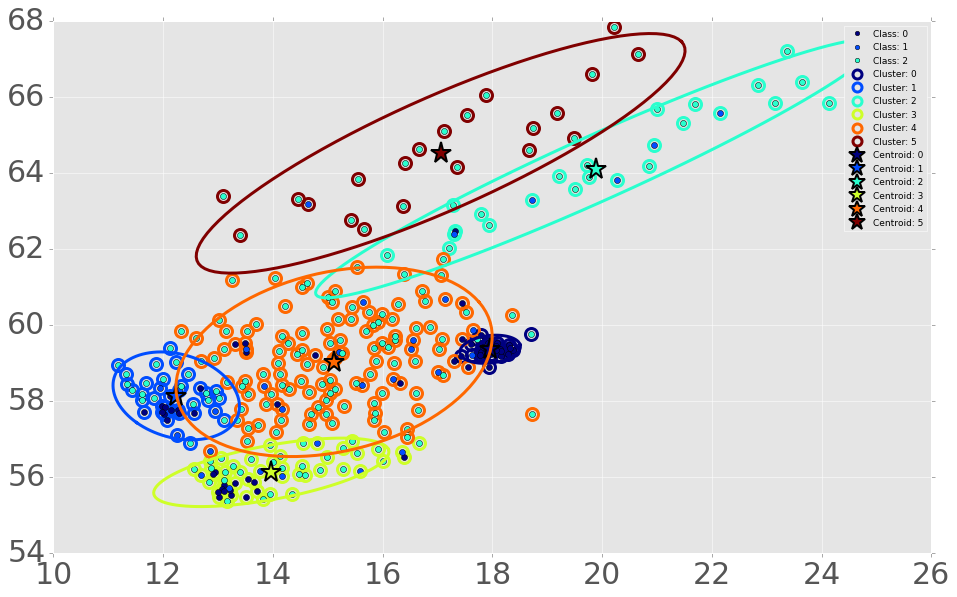

In [69]:
def encode_type(x):
    if x == 'City':
        return 0
    elif x == 'Town':
        return 1
    else:
        return 2
    
# list_of_variables = ['medianIncome','cars','tractors','snowmobiles','motorcycles','reportedCrime','population','foreignBorn']
list_of_variables = ['longitude','latitude']
data['typeEncoded'] = data['municipalityTypeBroad'].apply(encode_type)


X = np.matrix(data[list_of_variables])
y = np.matrix(data['municipalityTypeBroad'].apply(encode_type))
colors = np.matrix(data['typeEncoded'])
N, M = X.shape

K = 6
cov_type = 'full'       
# type of covariance, you can try out 'diag' as well
reps = 3                
# number of fits with different initalizations, best result will be kept
# Fit Gaussian mixture model
gmm = GMM(n_components=K, covariance_type=cov_type, n_init=reps, params='wmc').fit(X)
cls = gmm.predict(X)    
# extract cluster labels
cds = gmm.means_        
# extract cluster centroids (means of gaussians)
covs = gmm.covars_      
# extract cluster shapes (covariances of gaussians)
if cov_type == 'diag':

    new_covs = np.zeros([K,M,M])

    count = 0

    for elem in covs:

        temp_m = np.zeros([M,M])

        for i in range(len(elem)):

            temp_m[i][i] = elem[i]

        new_covs[count] = temp_m

        count += 1

    covs = new_covs



# Plot results:

figure(figsize=(14,9))

clusterplot(X, clusterid=cls, centroids=cds, y=y, covars=covs)

show()

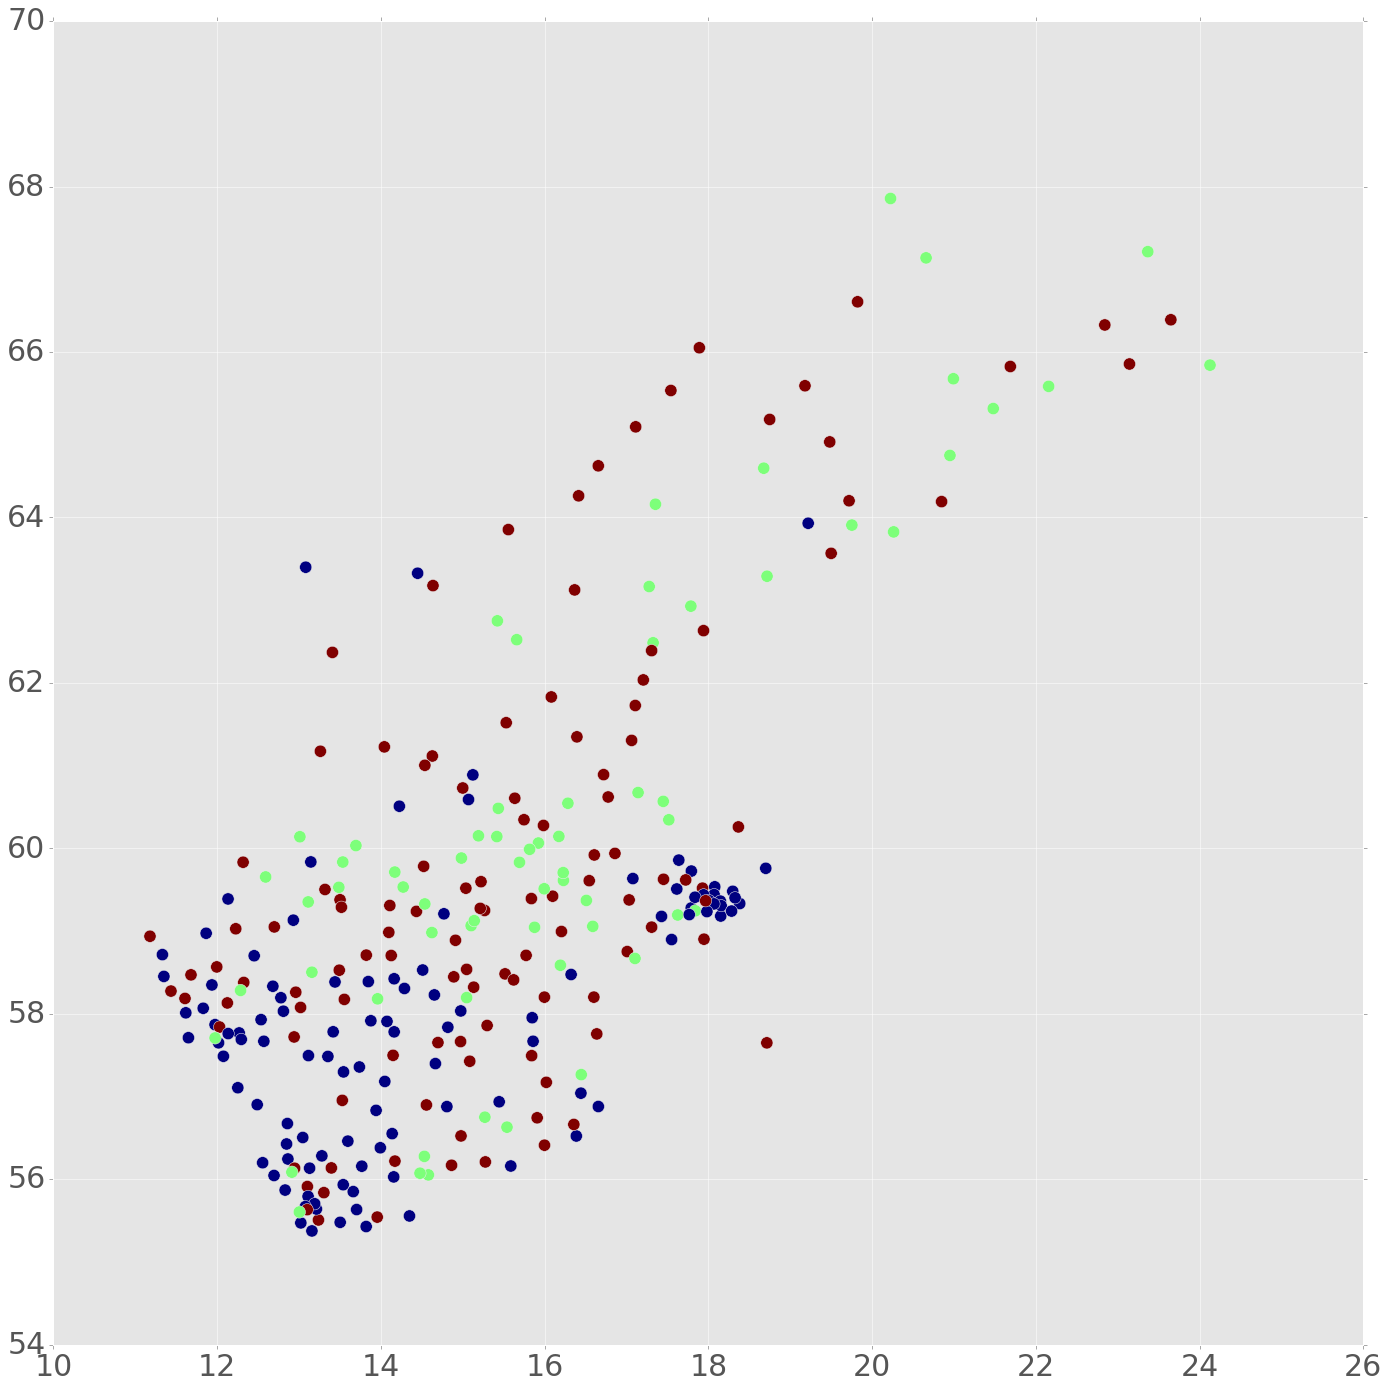

In [133]:
import matplotlib.pyplot as plt
import numpy as np

def governing_encode(x):
    if x == 'Conservative':
        return 0
    elif x == 'Left-wing':
        return 1
    else:
        return 2
    
def governing_marking_encode(x):
    if x == 'Conservative':
        return 'o'
    elif x == 'Left-wing':
        return 'v'
    else:
        return '*'

markers = ['o', 'v', '*']

data['governingEncoded'] = data['governing'].apply(governing_encode)

list_of_variables = ['longitude','latitude']
X = np.array(data[list_of_variables])
y = np.array(data['governingEncoded'])
markers = list(data['governing'].apply(governing_marking_encode))
colors = np.array(y)

scatter(X[:,0], X[:,1], c=colors, s=150)

fig.show()

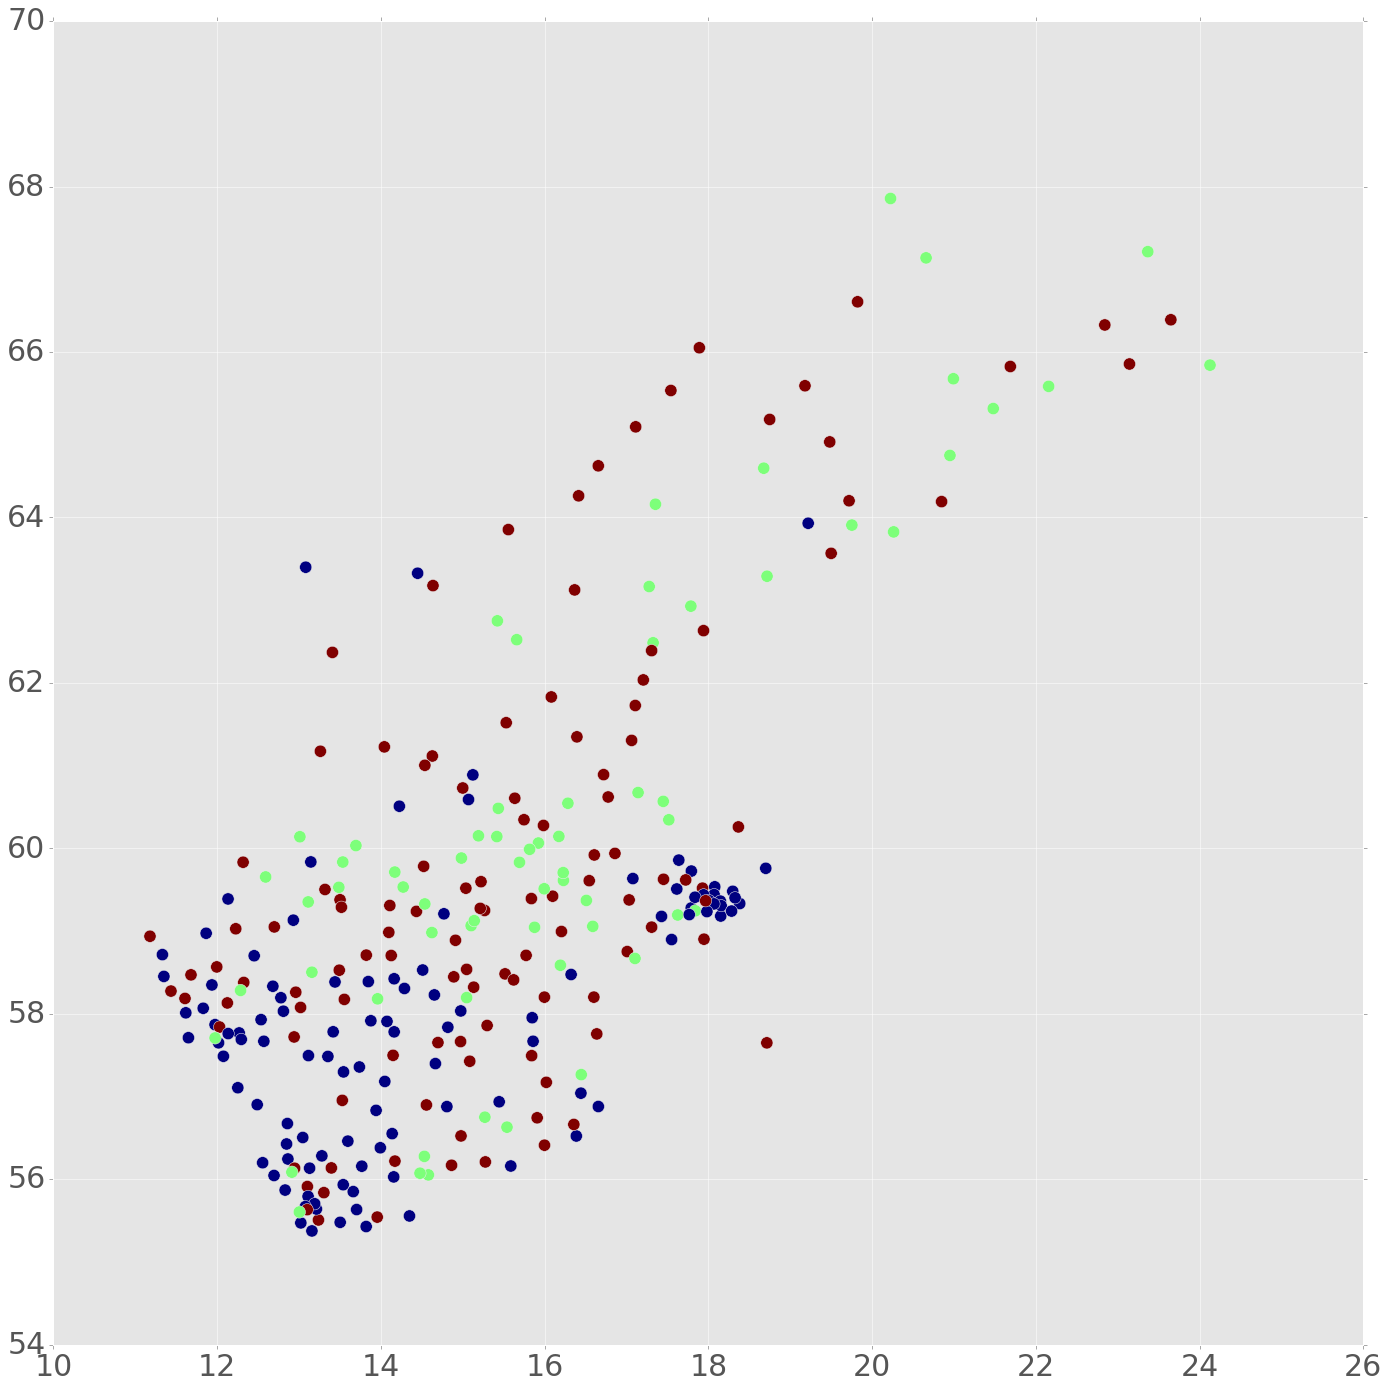

In [149]:
import matplotlib.pyplot as plt
import numpy as np

def municipalityTypeEncoded(x):
 for index,type_ in enumerate(data.municipalityType.unique()):
    if x == type_:
        return index



data['municipalityTypeEncoded'] = data['municipalityType'].apply(municipalityTypeEncoded)

list_of_variables = ['longitude','latitude']
X = np.array(data[list_of_variables])
y = np.array(data['governingEncoded'])

colors = np.array(y)

scatter(X[:,0], X[:,1], c=colors, s=150)

fig.show()

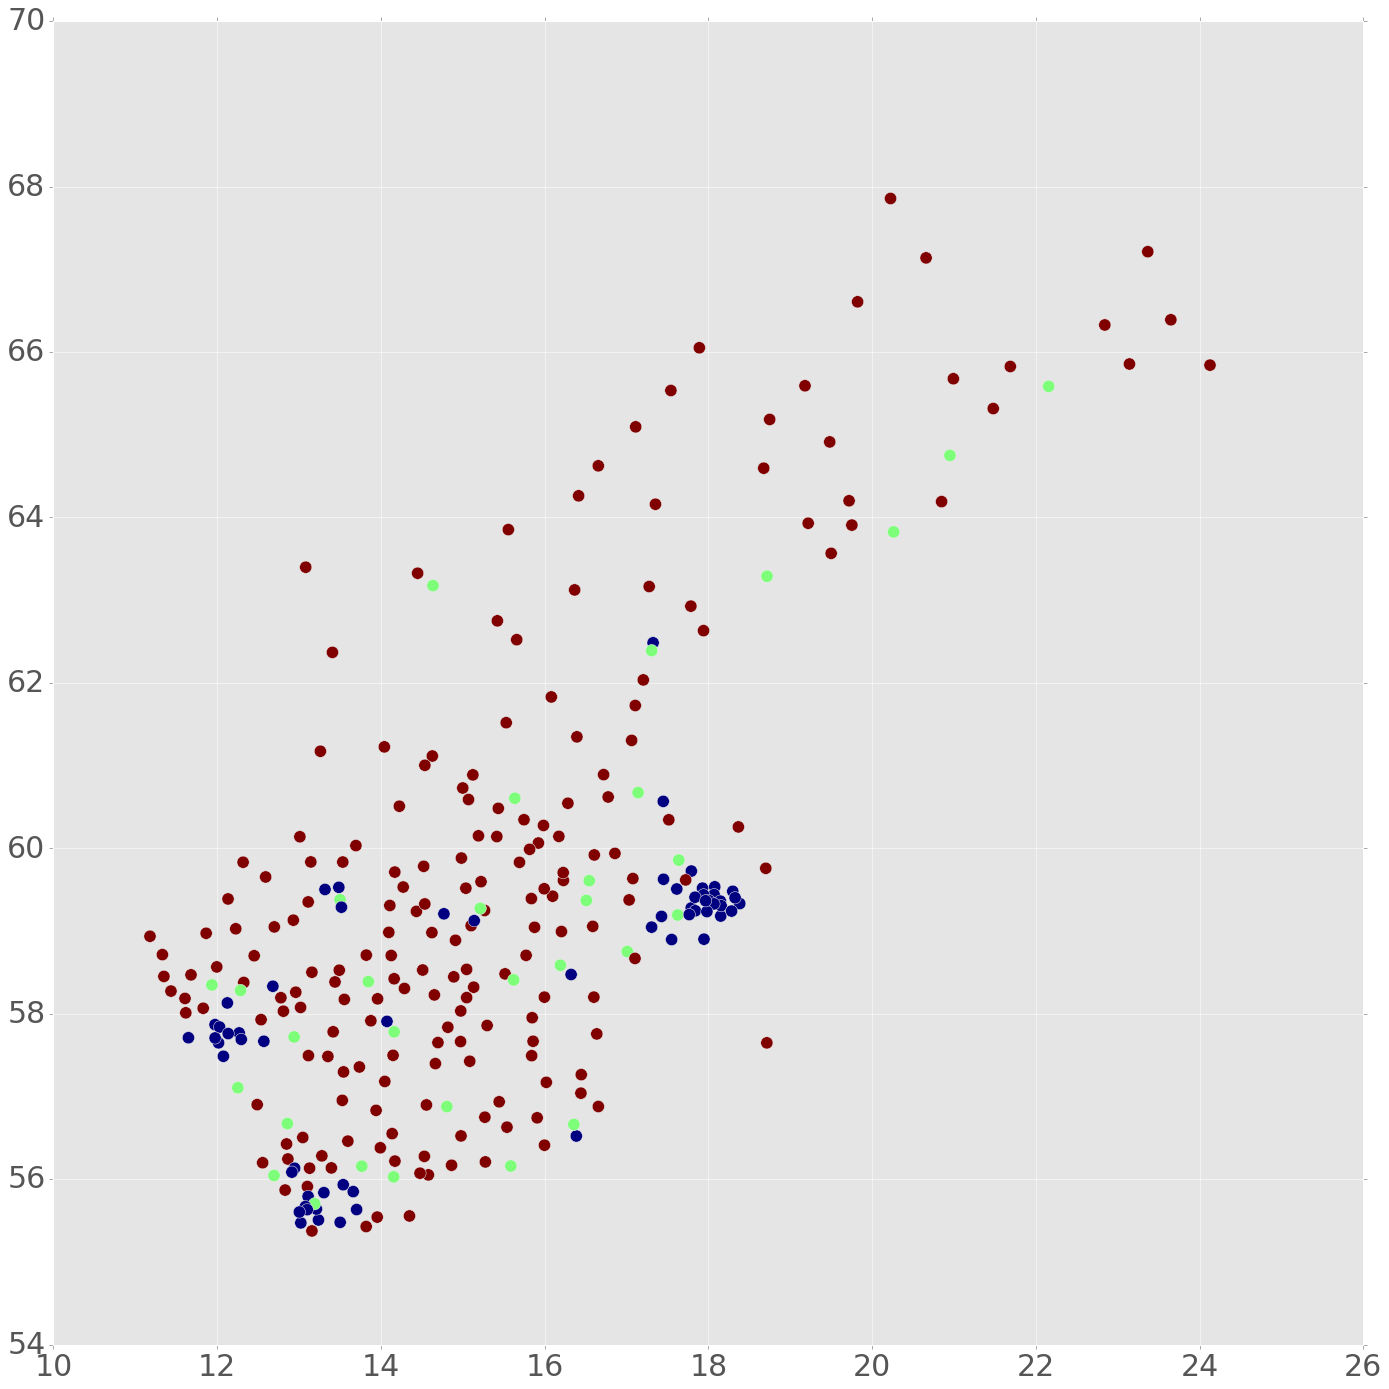

In [150]:
import matplotlib.pyplot as plt
import numpy as np
def encode_type(x):
    if x == 'City':
        return 0
    elif x == 'Town':
        return 1
    else:
        return 2

list_of_variables = ['longitude','latitude']
X = np.array(data[list_of_variables])
y = np.array(data['municipalityTypeBroad'].apply(encode_type))
colors = np.array(data['typeEncoded'])

scatter(X[:,0], X[:,1], c=colors, s=150)

fig.show()

/home/adam/anaconda2/envs/deeplearning/lib/python2.7/site-packages/ipykernel/__main__.py:437: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/home/adam/anaconda2/envs/deeplearning/lib/python2.7/site-packages/ipykernel/__main__.py:441: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/home/adam/anaconda2/envs/deeplearning/lib/python2.7/site-packages/ipykernel/__main__.py:456: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/home/adam/anaconda2/envs/deeplearning/lib/python2.7/site-packages/ipykernel/__main__.py:460: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


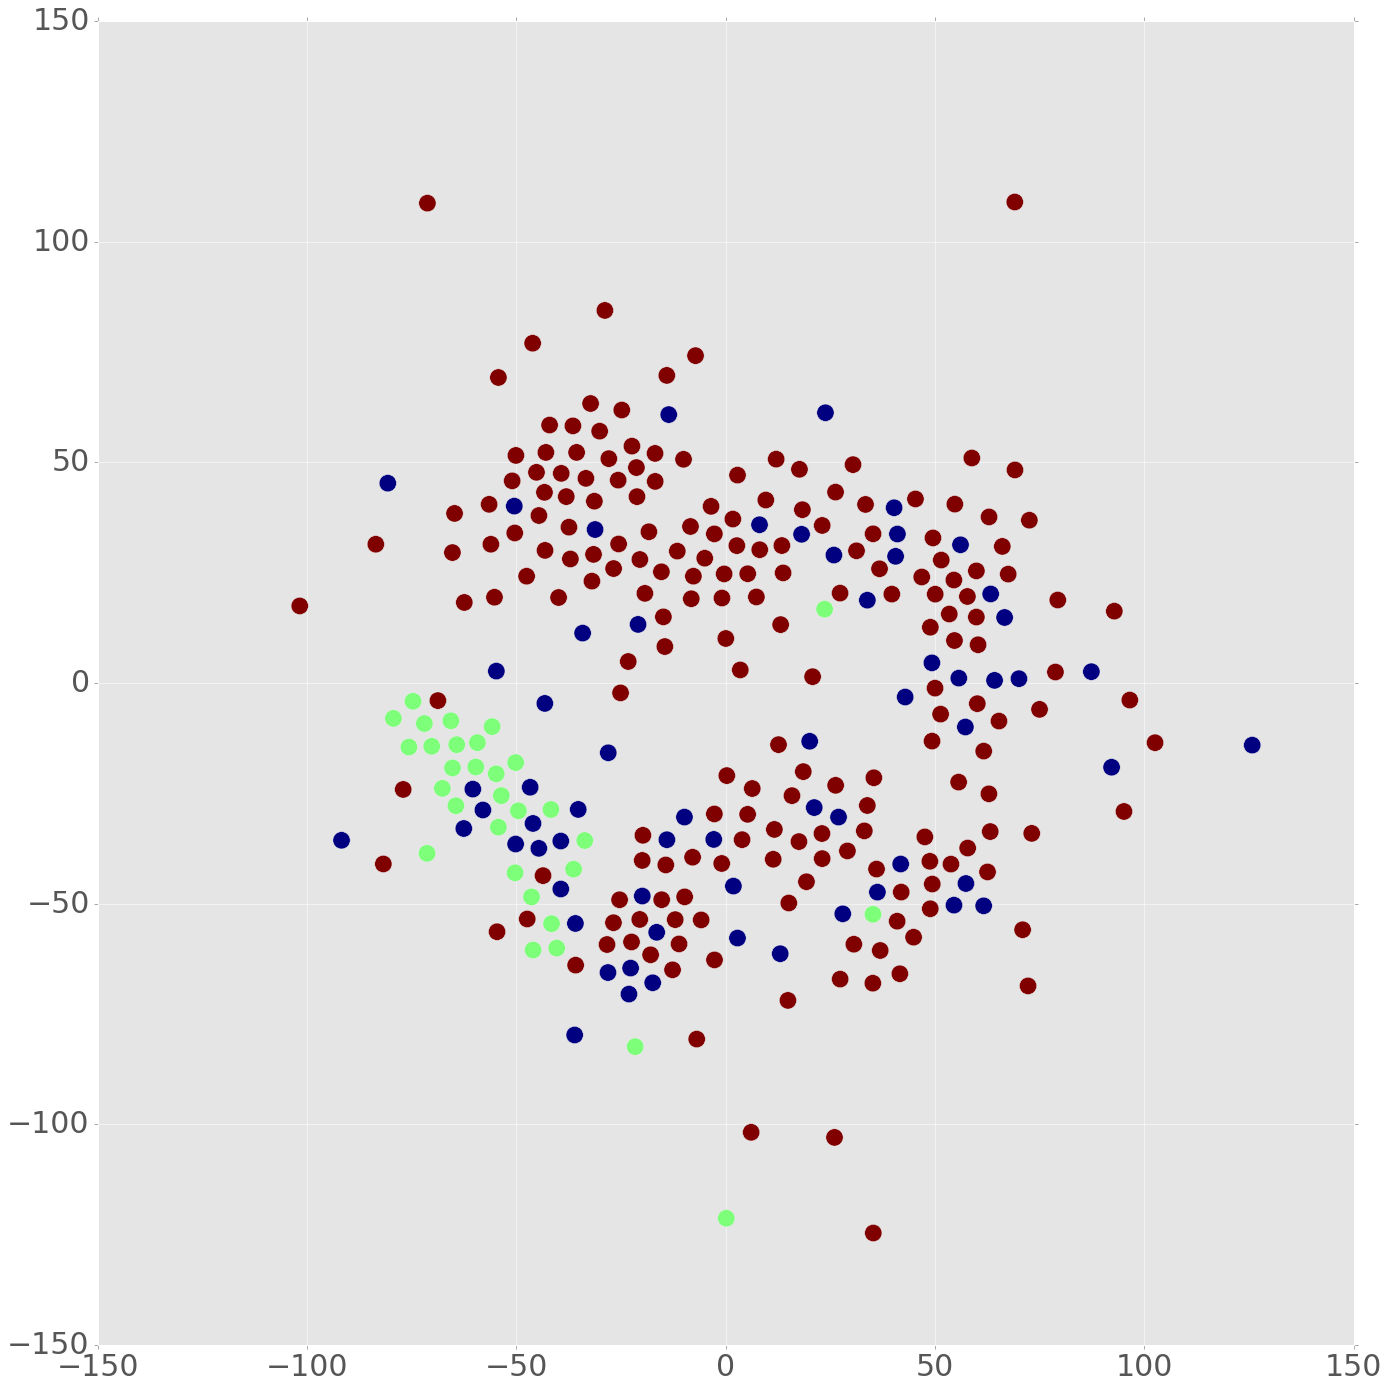

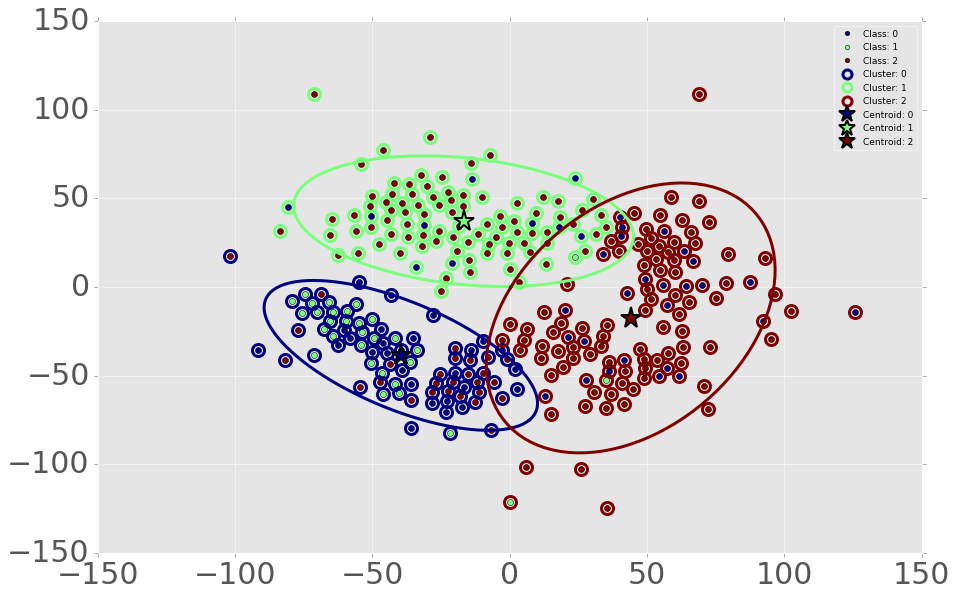

In [175]:
from sklearn.manifold import TSNE

list_of_variables = ['cars','tractors','snowmobiles','motorcycles' ,'fokusRanking','population',
                     'hasEducation','urbanDegree','reportedCrime','reportedCrime','rentalApartments',
                     'youngUnskilled','asylumCosts','reportedCrimeVandalism']
                     
    
y_variable = 'typeEncoded'

X_to_transform = np.array(data[list_of_variables])
X_normalized =  (X_to_transform - X_to_transform.mean()) / (X_to_transform.max() - X_to_transform.min())

tsne_model = TSNE(n_components=2,random_state=0,perplexity=30,n_iter=200)
X_reduced_with_TSNE = tsne_model.fit_transform(X_normalized)
colors = np.array(data[y_variable])



scatter(X_reduced_with_TSNE[:,0],X_reduced_with_TSNE[:,1],c=colors, s=300)



y = np.matrix(data[y_variable])
colors = np.matrix(data[y_variable])
N, M = X_reduced_with_TSNE.shape

K = len(data.municipalityTypeBroad.unique())
cov_type = 'full'       
# type of covariance, you can try out 'diag' as well
reps = 3                
# number of fits with different initalizations, best result will be kept
# Fit Gaussian mixture model
gmm = GMM(n_components=K, covariance_type=cov_type, n_init=reps, params='wmc').fit(X_reduced_with_TSNE)
cls = gmm.predict(X_reduced_with_TSNE)    
# extract cluster labels
cds = gmm.means_        
# extract cluster centroids (means of gaussians)
covs = gmm.covars_      
# extract cluster shapes (covariances of gaussians)
if cov_type == 'diag':

    new_covs = np.zeros([K,M,M])

    count = 0

    for elem in covs:

        temp_m = np.zeros([M,M])

        for i in range(len(elem)):

            temp_m[i][i] = elem[i]

        new_covs[count] = temp_m

        count += 1

    covs = new_covs



# Plot results:

figure(figsize=(14,9))

clusterplot(X_reduced_with_TSNE, clusterid=cls, centroids=cds, y=y, covars=covs)

show()
